# Building our own Face Detection model

This model comes along my "FaceID project". It's the first part of this project which should classify if a photo contains a face or no. 

It's a binary classification and uses the bases of a ResNet50 model (pretrained on [ImageNet](https://image-net.org/)) and then, fine tuned with faces drawn from the [LFW database](http://vis-www.cs.umass.edu/lfw/) and backgrounds drawn from [House Rooms dataset](https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset). 

This model is known as a *face detection* model (opposed to a *face recognition* model which will see in detail in the next part). It classifies whether there is a face (a person) or not in a image. The output of the model is binary (0 or 1) where 0 means there is no face and 1 there is a face.

# Import

In [ ]:
import os

import numpy as np
import glob
import pickle
import tqdm
import random as rd
import time

import torch
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms

from PIL import Image

/Users/thierryksstentini/opt/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class FaceDetection_dataset(Dataset):
    def __init__(self, imgset_face:list, imgset_noface:list, val_stride:int=0, isValSet_bool:bool=False, 
                 isAugment_bool:bool=False, isNormalize_bool:bool=False):
        """
        Class that build the dataset to feed the Pytorch Dataloader 

        -------------------
        Class attributs:
            imgset_face: list of PIL images
                The list of PIL images with face in it
            imgset_face: list of PIL images.
                The list of PIL images without face in it (typically random
                background found in the 'houseroom dataset').
            val_stride: int
                Use to select training images and validation images without data
                leaks.
            isValSet_bool: bool
                Boolean to construct a validation dataset
            isAugment_bool: bool
                Boolean to activate the data augmentation preprocessing
            isNormalize_bool: bool
                Boolean to activate normalization of each image by its own mean
                and std values.
        """
        
        self.isAugment_bool = isAugment_bool
        self.isNormalize_bool = isNormalize_bool
        
        self.imgset = imgset_face + imgset_noface        
        
        label_face = np.ones(len(imgset_face)).tolist()
        label_noface = np.zeros(len(imgset_noface)).tolist()
        self.labelset = label_face + label_noface
        
        if isValSet_bool:
            assert val_stride > 0, 'val_stride should be greater than zero'
            self.imgset = self.imgset[::val_stride]
            self.labelset = self.labelset[::val_stride]
       
        elif val_stride > 0:
            del self.imgset[::val_stride]
            del self.labelset[::val_stride]

    def preprocess(self, img)->torch.Tensor:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((256, 256)), 
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        img_t = transform(img)
        
        if self.isAugment_bool:
            """ to do """
            augment = torchvision.transforms.Compose([
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.RandomRotation(degrees=(-10,10))
            ])
            img_t = augment(img_t)
        

        if self.isNormalize_bool:
            mean, std = img_t.mean(), img_t.std()
            img_t = (img_t - mean) / std

        return img_t



    def __len__(self):
        return len(self.imgset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.imgset[idx]
        image = self.preprocess(image)
        
        label = self.labelset[idx]
            
        return image, torch.tensor(label).to(torch.float32)


# Loading data

### Working in the CLOUD

In [ ]:
### https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset
### http://vis-www.cs.umass.edu/lfw/

data_path = '/content/drive/MyDrive/Colab Notebooks'

#----------------------------- Loading images with a face ---------------------#
#imgset_face_path = glob.glob(data_path + '/face_verification/*dataset/*lfw/*/*')
#imgset_face_PIL = [Image.open(k).convert('RGB') for k in imgset_face_path]
with open(data_path + '/face_verification/dataset/dataset_augmented/lfw_PIL.pkl', 'rb') as lfw_PIL:
    imgset_face_PIL = pickle.load(lfw_PIL)


#----------------------------- Loading images without face --------------------#
#imgset_noface_path = glob.glob(data_path + '/face_verification/*dataset/*houseroom/*/*')
#imgset_noface_PIL = [Image.open(k).convert('RGB') for k in imgset_noface_path]
with open(data_path + '/face_verification/dataset/houseroom/houseroom_3000_PIL.pkl', 'rb') as houseroom_PIL:
    imgset_noface_PIL = pickle.load(houseroom_PIL)### https://www.kaggle.com/datasets/robinreni/house-rooms-image-dataset
### http://vis-www.cs.umass.edu/lfw/

### Working in LOCAL MACHINE

In [ ]:
data_path = '/Users/thierryksstentini/Downloads/dataset'

#----------------------------- Loading images with a face ---------------------#
with open(data_path + '/dataset_augmented/lfw_PIL.pkl', 'rb') as lfw_PIL:
    imgset_face_PIL = pickle.load(lfw_PIL)


#----------------------------- Loading images without face --------------------#
with open(data_path + '/houseroom_3000_PIL.pkl', 'rb') as houseroom_PIL:
    imgset_noface_PIL = pickle.load(houseroom_PIL)

In [ ]:
#----------------------------- Creating datasets ------------------------------#
dataset_train = FaceDetection_dataset(imgset_face_PIL, imgset_noface_PIL, val_stride=10, isValSet_bool=False, isAugment_bool=True)
dataset_val = FaceDetection_dataset(imgset_face_PIL, imgset_noface_PIL, val_stride=10, isValSet_bool=True)

del imgset_face_PIL, imgset_noface_PIL

#----------------------------- Creating loaders -------------------------------#
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)

# Creating the model

In [ ]:
class resNet50_custom(torch.nn.Module):
    def __init__(self):
        super(resNet50_custom, self).__init__()
        self.res50 = torchvision.models.resnet50(pretrained = True, progress = True)
        for param in self.res50.parameters():
            param.requires_grad = False
        self.res50.fc = nn.Linear(2048, 1)

    def forward(self, input):
        output = self.res50(input)
        return torch.sigmoid(output)


In [ ]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
resNet50_model = resNet50_custom()
optimizer = torch.optim.Adam(resNet50_model.parameters(), lr=0.001)
num_epochs = 3
summary(resNet50_model, (32, 3, 224, 224));

In [ ]:
### Choosing device between CPU or GPU
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('mps') if torch.has_mps else torch.device('cpu')
print("\n------------------------------------")
print(f"Execute notebook on - {device} -")
print("------------------------------------\n")


------------------------------------
Execute notebook on - mps -
------------------------------------



# Building the training loop function

In [ ]:
def model_loop(model, epochs, trainloader, validloader, optimizer, loss_fn, device):
    model.to(device)
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} on {device} \n-------------------------------")
        model.train()
        train_loss = 0.0
        size = len(trainloader.dataset)
        
        for batch, (data, labels) in enumerate(trainloader):
            # Transfer Data to GPU if available
            data, labels = data.to(device), labels.to(device)

            # Clear the gradients
            optimizer.zero_grad()

            # Make prediction & compute the mini-batch training loss
            preds = model(data)
            loss = loss_fn(preds, labels.unsqueeze(1))

            # Compute the gradients
            loss.backward()

            # Update Weights
            optimizer.step()

            # Aggregate mini-batch training losses
            train_loss += loss.item()
            train_loss_list.append(train_loss)

            
            if batch == 0 or batch % 10 == 0:
                loss, current = loss.item(), (batch+1) * len(data)
                print(f"mini-batch loss for training : {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        # Compute the global training loss as the mean of the mini-batch training losses
        train_loss /= len(trainloader)
      
        model.eval()
        valid_loss = 0.0
        # Test part : no gradient update
        with torch.no_grad():
            for batch, (data, labels) in enumerate(validloader):
                # Transfer Data to GPU if available
                data, labels = data.to(device), labels.to(device)
                # Forward Pass & compute the mini-batch validation loss
                preds = model(data)
                loss = loss_fn(preds,labels.unsqueeze(1))

                # Calculate Loss
                valid_loss += loss.item()
                valid_loss_list.append(valid_loss)

                if batch==0 or batch % 10 == 0:
                    loss, current = loss.item(), (batch+1) * len(data)
                    print(f"mini-batch loss for validation : {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        # Compute the global validation loss as the mean of the mini-batch validation losses
        valid_loss /= len(validloader)

        print(f"Epoch {epoch+1} \n Training Loss: {train_loss:>7f} \n Validation Loss: {valid_loss:>7f}" )

    return train_loss_list, valid_loss_list


# Training

In [ ]:
loss = nn.BCELoss()
train_loss, valid_loss = model_loop(model = resNet50_model,
                                    epochs = num_epochs,
                                    trainloader = train_dataloader,
                                    validloader = val_dataloader,
                                    optimizer = optimizer,
                                    loss_fn = loss,
                                    device = device) 

Epoch 1 on mps 
-------------------------------
mini-batch loss for training : 0.688751  [   64/ 5536]
mini-batch loss for training : 0.238309  [  704/ 5536]
mini-batch loss for training : 0.100315  [ 1344/ 5536]
mini-batch loss for training : 0.055533  [ 1984/ 5536]
mini-batch loss for training : 0.035146  [ 2624/ 5536]
mini-batch loss for training : 0.033834  [ 3264/ 5536]
mini-batch loss for training : 0.021570  [ 3904/ 5536]
mini-batch loss for training : 0.016549  [ 4544/ 5536]
mini-batch loss for training : 0.031210  [ 5184/ 5536]
mini-batch loss for training : 0.023273  [ 2784/ 5536]
mini-batch loss for validation : 0.026839  [   64/ 5536]
mini-batch loss for validation : 0.028523  [  400/ 5536]
Epoch 1 
 Training Loss: 0.099469 
 Validation Loss: 0.024951
Epoch 2 on mps 
-------------------------------
mini-batch loss for training : 0.021280  [   64/ 5536]
mini-batch loss for training : 0.015328  [  704/ 5536]
mini-batch loss for training : 0.014916  [ 1344/ 5536]
mini-batch lo

In [ ]:
losses = {'train_loss' : train_loss, 'valid_loss' : valid_loss}
import pickle
with open("losses_resNet50_FaceDetection_VSC.pickle", "wb") as file:
    pickle.dump(losses, file)

In [ ]:
def test_accuracy(model, validloader, device):
    correct_results_sum = 0
    total = len(validloader.dataset)
    model.eval()

    # test part : no gradient update
    with torch.no_grad():
        for imgs, labels in validloader :
            # Transfer Data to GPU if available
            imgs, labels = imgs.to(device), labels.to(device)

            # Prediction on unseen data as 0 or 1
            outputs = model(imgs)
            predicted = torch.round(outputs).squeeze(1)
            print(imgs.shape)
            # Aggregate and sum the correct predictions for each mini-batch
            correct_results_sum += (predicted == labels).sum().float()

    # Mean of the mini-batch correct predictions
    acc = correct_results_sum / total
    acc = torch.round(acc * 100)
    print("Validation accuracy : {:.2f}".format(acc))

In [ ]:
test_accuracy(resNet50_model, val_dataloader, device)

In [ ]:
def preprocess_test(img)->torch.Tensor:
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)), 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return transform(img)


import glob
list_img = glob.glob('/Users/thierryksstentini/Downloads/dataset/test2/*')

for k in list_img:
    img_PIL = Image.open(k).convert('RGB')
    frame_preprocess = preprocess_test(img_PIL)
    resNet50_model.to('cpu')
    resNet50_model.eval()
    with torch.no_grad():
        pred = resNet50_model(frame_preprocess.unsqueeze(0))
    print("Prediction en sortie de sigmoid : ", pred)

In [ ]:
torch.save(resNet50_model.state_dict(), 'weights_resNet50_FaceDetection_VSC.pth')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open('losses_resNet50_FaceDetection_VSC.pickle', 'rb') as pkl:
    losses = pickle.load(pkl)

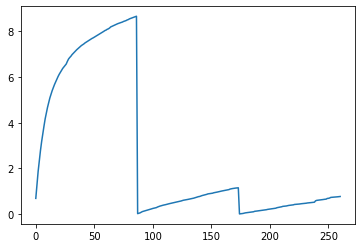

In [ ]:
train_loss = losses['train_loss']
valid_loss = losses['valid_loss']

train_loss_a = np.array(train_loss)
#valid_loss_a = np.array(valid_loss)

plt.plot(train_loss_a)
#plt.plot(valid_loss_a)